In [1]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import DataLoader, Dataset

import numpy as np
import os, sys
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
sys.dont_write_bytecode = True

In [4]:
class MyDataSet(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x = self.data[idx]
        return x

class Student(nn.Module):
    def __init__(self, n_dim, n_hid):
        super(Student, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_dim, n_dim//2),
            nn.ReLU(),
            nn.Linear(n_dim//2, n_dim//4),
            nn.ReLU(),
            nn.Linear(n_dim//4, n_hid)
        )

        self.decoder = nn.Sequential(
            nn.Linear(n_hid, n_dim//4),
            nn.ReLU(),
            nn.Linear(n_dim//4, n_dim//2),
            nn.ReLU(),
            nn.Linear(n_dim//2, n_dim)
        )
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()
        self.n_dim = n_dim

    def forward(self, x):
        x = self.z_score.transform(x)
        x = [x[i-self.n_dim:i] for i in range(self.n_dim, len(x))]
        x = torch.tensor(x).to(torch.float32)
        x = self.quant(x)
        out = self.encoder(x)
        out = self.decoder(out)
        out = self.dequant(out)
        return out[:, -1].tolist()
    
    def anomaly(self, x):
        x = self.z_score.transform(x)
        x = [x[i-self.n_dim:i] for i in range(self.n_dim, len(x))]
        x = torch.tensor(x).to(torch.float32)
        qx = self.quant(x)
        out = self.encoder(qx)
        out = self.decoder(out)
        out = self.dequant(out)
        return torch.mean((out - x)**2, dim=1).tolist()

    def _train(self, x):
        x -= float(self.z_score.mu)
        x /= float(self.z_score.std)
        x = self.quant(x)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        x_hat = self.dequant(x_hat)
        z = self.dequant(z)
        return x_hat, z
    
    def set_z_score(self, z_score):
        self.z_score = z_score
    

def train_process(dataloader, teacher, student, optimizer):
    total_loss_val = 0.0
    feat_loss_val = 0.0
    for data in dataloader:
        true, _, teacher_z, _ = teacher._train(data.to(next(teacher.parameters()).device))
        pred, student_z = student._train(data)
        soft_trg_loss = nn.MSELoss()(pred, true.to("cpu"))
        feat_loss = nn.MSELoss()(student_z, teacher_z.to("cpu"))
        loss = soft_trg_loss + feat_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss_val += loss.item()
        feat_loss_val += feat_loss.item()
    return total_loss_val, feat_loss_val

def fit(data, teacher):
    teacher.fit(data)
    student = Student(teacher.n_dim, (teacher.n_hid2 * 2 + teacher.n_dim)//8)
    student.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
    torch.quantization.prepare_qat(student, inplace=True)

    teacher.eval()
    student.train()
    optimizer = optim.AdamW(student.parameters(), lr = 1e-4, weight_decay = 1e-2)
    epoch = 0
    history = []
    Z_score = z_score(data)
    data = Z_score.transform(data)
    student.set_z_score(Z_score)
    x = torch.tensor([data[i-teacher.n_dim:i] for i in range(teacher.n_dim, len(data))]).to(torch.float32)
    dataloader = DataLoader(MyDataSet(x), batch_size = 128, shuffle = True)
    while True:
        try:
            epoch += 1
            TL, FL = train_process(dataloader, teacher, student, optimizer)
            history += [[TL, FL]]
            fig, ax = plt.subplots(1, 2, figsize = (12, 2))
            clear_output()
            ax[0].plot(np.array(history)[:, 0], color = "blue")
            ax[1].plot(np.array(history)[:, 1], color = "green")
            ax[0].grid()
            ax[1].grid()
            plt.title(f"Epoch {epoch}")
            plt.show()
            if epoch == 80: break
        except KeyboardInterrupt:
            break
    
    torch.quantization.convert(student, inplace=True)
    return student
    
class z_score:
    def __init__(self, x):
        self.mu = np.mean(x)
        self.std = np.std(x)
    def transform(self, data):
        out = (np.array(data) - self.mu)/self.std
        return out

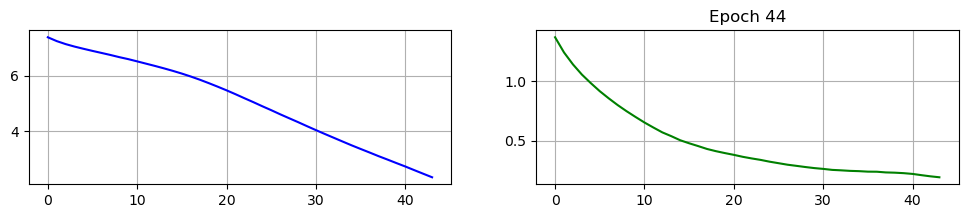

In [5]:
from model import FCVAE
data = np.sin(np.linspace(0, np.pi*20, 1000)).tolist()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher = FCVAE(n_dim = 256, n_hid1 = 64, n_hid2 = 32, n_seq = 128).to(device)
student = fit(data, teacher)

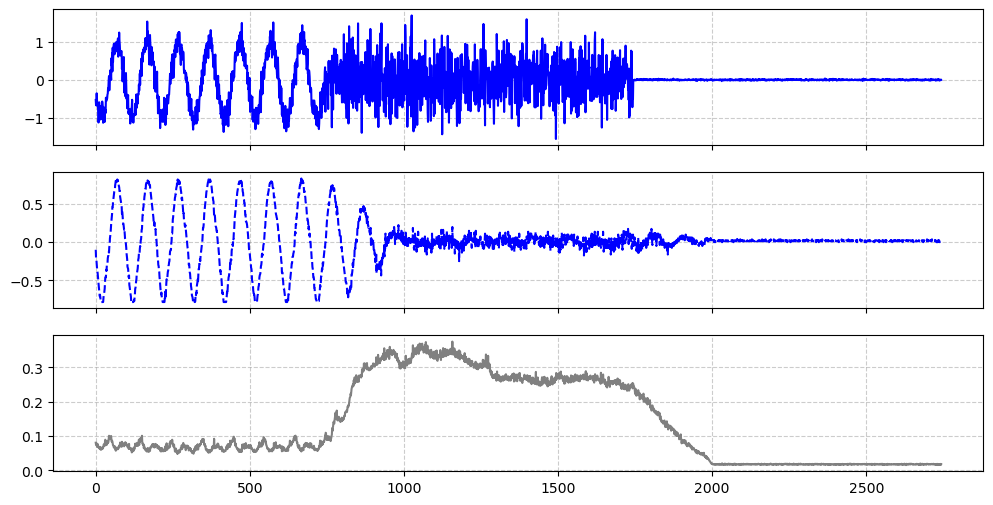

In [4]:
ts_data = (np.sin(np.linspace(0, np.pi*20, 1000)) + np.random.normal(0, 0.2, size = (1000, ))).tolist() + np.random.normal(0, 0.5, size = (1000, )).tolist() + np.random.normal(0, 0.01, size = (1000, )).tolist()
fig, ax = plt.subplots(3, 1, figsize = (12, 6), sharex=True)
with torch.no_grad():
    student.eval()
    anomalies = student.anomaly(ts_data)
    recon = student(ts_data)
ax[0].plot(ts_data[-len(anomalies):], color = "blue")
ax[0].grid(color = "gray", linestyle = "--", alpha = .4)
ax[1].plot(recon, color = "blue", linestyle = "--")
ax[1].grid(color = "gray", linestyle = "--", alpha = .4)
ax[2].plot(anomalies, color = "gray")
ax[2].grid(color = "gray", linestyle = "--", alpha = .4)
plt.show()